In [3]:
import pandas as pd
import numpy as np
import re
from config import *

# Sklearn
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score

# Visual
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns

In [7]:
data = pd.read_parquet(FEATURES_DIR / "features.pq")
y = data["y"]
X = data.drop(["participant_id", "y"] ,axis=1)


In [8]:
# Dicts to save WCSS and BCSS
silhouette_scores = {"n_clusters" : [], "Silhouette score" : []}
cluster_purity = {"n_clusters" : [], "Cluster purity" : []}

pca = PCA(n_components=2)

n_splits=5
skf = StratifiedKFold(n_splits=n_splits)

y_subset = y[y==1]
X_subset = X[y==1] # .drop("info_injury:0",axis=1)

for n_clusters in range(2,11):
    model = AgglomerativeClustering(n_clusters=n_clusters, linkage="ward")
    model.fit(X_subset)

    # Compute silhouette score
    sil_score = silhouette_score(X_subset, model.labels_)

    # Compute Purity Score (how well clusters match patient/control labels)
    contingency_matrix = np.zeros((n_clusters, 2))  # Assuming two classes (patients & controls)
    for k in range(n_clusters):
        if np.any(model.labels_ == k):
            contingency_matrix[k, 0] = np.sum((model.labels_ == k) & (y_subset == 0))  # Controls
            contingency_matrix[k, 1] = np.sum((model.labels_ == k) & (y_subset == 1))  # Patients
    cps_score = np.sum(np.max(contingency_matrix, axis=1)) / np.sum(contingency_matrix)

    silhouette_scores["n_clusters"].append(n_clusters)
    silhouette_scores["Silhouette score"].append(sil_score)

    cluster_purity["n_clusters"].append(n_clusters)
    cluster_purity["Cluster purity"].append(cps_score)

<Axes: xlabel='n_clusters', ylabel='Silhouette score'>

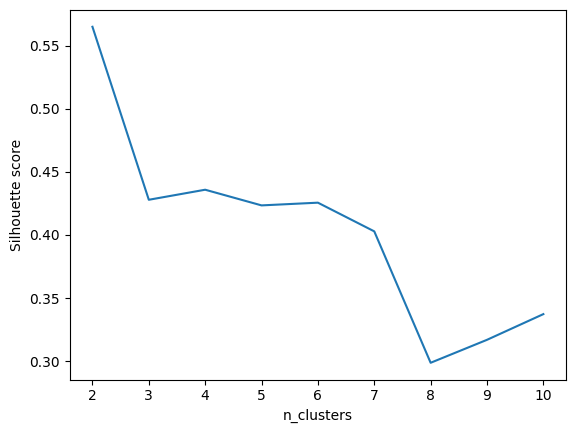

In [9]:
silhouette_score_df = pd.DataFrame.from_dict(silhouette_scores)

sns.lineplot(data = silhouette_score_df, x="n_clusters", y="Silhouette score")

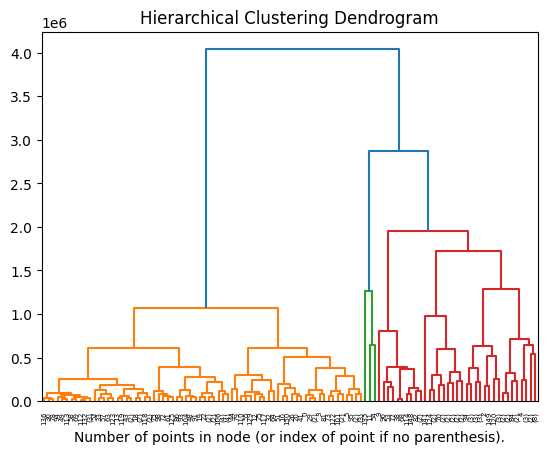

In [28]:
from scipy.cluster.hierarchy import dendrogram

def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)


# setting distance_threshold=0 ensures we compute the full tree.
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None)

model = model.fit(X)
plt.title("Hierarchical Clustering Dendrogram")
# plot the top three levels of the dendrogram
plot_dendrogram(model, truncate_mode="level", p=7)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()


In [23]:
model.n_clusters_

154